# **Multiple Linear Regression**

In [ ]:
!pip install pygam
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [ ]:
%matplotlib inline

# A reminder : the simple linear regression

We consider a data set that provides the number of years a worker was exposed
to cotton dust (*Exposure*) versus a measure of lung capacity (*PEFR* or *Peak Expiratory Flow Rate*)

In [ ]:
# Load the data
lung = pd.read_csv(os.path.join('sample_data', 'LungDisease.csv'))
lung.head()

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1


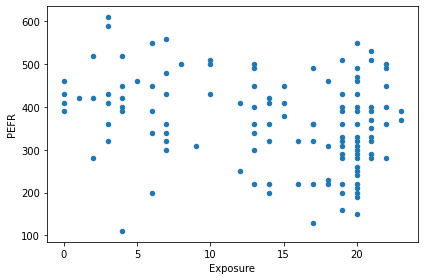

In [ ]:
# Let us visualize the covariation of the two variables using a scatterplot
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

# NB:
# In this example, it is hard to have a clear conclusion on the strenght
# of the relationship

In [ ]:
# We can fit a linear regression model 'LinearRegression' model from 'scikit-learn'.
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

# NB:
# We predit the PEFR (outcome, dependant variable) with the Exposure variable
# (feature, independant variable)

Intercept: 424.583
Coefficient Exposure: -4.185


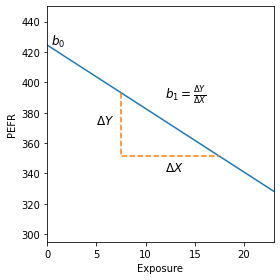

In [ ]:
# We can plot the fitted line
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5,17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

# NB:
# Intercept: bo, corresponds to a PEFR for soemone with zero year of Exposure
# Slope: b1, for each additional year, the PEFR is reduced of -4.185

In [ ]:
# We can obtain the fitted values using 'predict' and 
# then deduce the residuals 'residuals'
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

print('# -- Fitted values')
print(fitted[:5,])

print('# -- Residuals')
print(residuals.tolist()[:5])

# -- Fitted values
[424.58280657 424.58280657 424.58280657 424.58280657 420.39823009]
# -- Residuals
[-34.58280657395699, -14.582806573956987, 5.4171934260430135, 35.41719342604301, -0.3982300884955521]


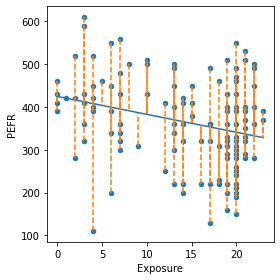

In [ ]:
# We can plot the residuals within the scatterplot
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

# Multiple Linear Regression

We are interested in estimating the value of houses. County assessors must estimate the value of a house for the purposes of assessing taxes. The multiple linear regression enables us to predict the sales price from the other variables.

In [ ]:
# Load the data
house = pd.read_csv(os.path.join('sample_data', 'house_sales.csv'), sep='\t')
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [ ]:
# Amont the available features, we pick 'a priori' some interesting features
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

In [ ]:
# 'LinearRegression' handles the multiple linear regression
house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.83060360240793
 SqFtLot: -0.06046682065307607
 Bathrooms: -19442.84039832106
 Bedrooms: -47769.95518521438
 BldgGrade: 106106.96307898081


# Assessing the model

$\underline{Root Mean Squared Error}$ :
\begin{equation}
RMSE = \sqrt{\frac{\sum_{i=1}^n(y_i-\bar{y}_i)^2}{n}}
\end{equation}

$\underline{Residual Standard Error}$ :
\begin{equation}
RSE = \sqrt{\frac{\sum_{i=1}^n(y_i-\bar{y}_i)^2}{n-p-1}}
\end{equation}

$\underline{R^2}$ :
\begin{equation}
R^2 = \frac{E_{xplain}SS}{T_{otal}SS} = 1 - \frac{R_{esidual}SS}{T_{otal}SS}
\end{equation}

In [ ]:
# We can use Scikit-learn to get these metrics computed
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


In [ ]:
# We can also use 'statsmodels'
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

# NB:
# As statsmodels doesn't add an intercept automatically, we need to add a 
# constant column with value 1 to the predictors. 

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:05:44   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

# Model selection and Stepwise Regression

We can use additional variables to predict the outcome (eg. *basement size*, *year built*).

In [ ]:
# Let us add predictors by just modifiying the 'lm' formula
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

# NB: 
# - previous adjusted R2 = 0.540
# - new adjusted R2 = 0.595
# improvement (^_^)b

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:05:44   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

In [ ]:
# We can use 'stepwise_selection' to capture the interesting features
y = house[outcome]

# A function that returns a fitted model for a given set of variables
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

# A function returns a score for a given model and a set of variables
# 'AIC_score' is taken from the package dmba
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

# NB:
# We finally get a model for which several variables were dropped:
# SqFtLot, NbrLivingUnits, YrRenovated, NewConstruction

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201887
 BldgGrade: 137159.56022619773
 YrBuilt: -3565.4249392492993
 Bedrooms: -51947.38367361318
 Bathrooms: 42396.164527717796
 PropertyType_Townhouse: 84479.16203300405
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.055187017682


# Weighted regression

Some records may have more *weight* than others with regards to the outcome. For
instance, older records may be considered are less reliable. We can use weight for the regression to take this into account.

In [ ]:
# Let us consider 'DocumentDate' to determine the older sales.
# We can compute the weight as the number of years since 2005
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [ ]:
np.min(house.Year)

2006

In [ ]:
# We can fit again the model
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

# NB:
# The coefficient are slightly different.

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


# Factor variables in regression

The *factor* variables are the *categorical* variables. They take a limited number of discrete values. Regression requires *numerical* inputs. So, we should convert the factor variables into *dummy* variables that are a set of *binary* variables (ie., yes/no).

# Dummy variable representation

In the data set *house_sales*, there is one factor variable, *property type*, that can take three possible values: Multiplex, Single Family and Townhouse. We need to convert it to a set of binary variables. To do this, we can create a binary variable for each category.

In [ ]:
# Let us see few values of "property type"
print(house.PropertyType.head(7))

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
6        Townhouse
7    Single Family
Name: PropertyType, dtype: object


In [ ]:
# We can convert this factor to a set of binary variables with 'get_dummies'
print(pd.get_dummies(house['PropertyType']).head(7))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1
7          0              1          0


**Caution**: <br>
In the regression setting, a factor variable with *P* dsitinct levels is usually represented by a matrix with only $P-1$ columns. This is because a regression model typically includes an **intercept** term. With an intercept, once you have defined the values for $P-1$ binaries, the value for the $P^{th}$ is known and could be considered redundant.<br><br>

Adidng the $P^{th}$ column will cause a **multicollinearity** error. Perfect multicollinearity occurs when one predictor variable can be expressed as **linear combination** of others. Hence, **multicollinearity** occurs when:
- A variable is included multiple times by error
- $P$ dummies, instead of $P-1$ dummies, are created from a factor variable
- Two variables are nearly perfectly correlated with one another<br><br>

In the case of nonperfect multicollinearity, the software may obtain a solution, but the results may be unstable.

In [ ]:
# The keyword argument 'drop_first' will return P-1 columns
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(7))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1
7              1          0


In [ ]:
# We can now include the factor variable 'Property type'
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

# NB: 
# The first level of the factor variable is taken as reference.
# Hence, there is no coefficient of Multiplex since it is implicitly defined 
# when PropertyTypeSingle Family == 0 and PropertyTypeTownhouse == 0
#
# The coefficients are interpreted as relative to Multiplex. So, a home that is
# Single Family is worth almost $85,000 less, and a home that is Townhouse is
# worth over $115,000 less.

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503828
 SqFtLot: -0.07036798136813083
 Bathrooms: -15979.013473415205
 Bedrooms: -50889.73218483025
 BldgGrade: 109416.30516146179
 PropertyType_Single Family: -84678.21629549257
 PropertyType_Townhouse: -115121.97921609184


# Interpreting the regression equation

We want to understand the relationship between the predictors and the outcome. 

## Correlated predictors

We often cope with predictors that are correlated to some extend. 

In [ ]:
# Let us have a look at the coefficients of the regression
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

# NB:
# Coef. 'Bedrooms': It is negative, meaning that adding a bedroom
# decreases the price...
#
# Consider two houses of the same size; it is reasonnable to 
# that a home with more but smaller bedrooms is less
# desirable!

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201887
 BldgGrade: 137159.56022619773
 YrBuilt: -3565.4249392492993
 Bedrooms: -51947.38367361318
 Bathrooms: 42396.164527717796
 PropertyType_Townhouse: 84479.16203300405
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.055187017682


In [ ]:
# In fact, predictors 'Bedrooms', 'house size' and 'Bathrooms' are correlated
# Let us try another regression without these predictors
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

# NB:
# Have a look at the 'Bedrooms' coefficient.

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230215377
 BldgGrade: 248997.79366213758
 YrBuilt: -3211.7448621550866
 PropertyType_Single Family: -19898.495340502435
 PropertyType_Townhouse: -47355.4368733449


## Cofounding variables

It is an *omission* issue: an important variable is not included in the regression equation. In our example, we miss a variable that would indicate
the location, which is very important when predicting a house price.

In [ ]:
# Let us create the ZipGroup predictor from the ZipCode variable
# ZipCode has 80 different values. We will consolidate this variable
# into 5 categories.

print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

         98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
ZipCode  ...     32     31      9      7      4      4      3      1      1   

         98043  
ZipCode      1  

[1 rows x 80 columns]


In [ ]:
# Load the data
house = pd.read_csv(os.path.join('sample_data', 'house_sales.csv'), sep='\t')
house.head()

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [ ]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

In [ ]:
# Now, we add 'ZipGroup' to our multiple regression model
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

# NB:
# The less expensive area has the ZipCode 0.
# The most expensive area has the ZipCode 4.

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580157
 SqFtLot: 0.45498713854659023
 Bathrooms: 5928.425640001543
 Bedrooms: -41682.87184074475
 BldgGrade: 98541.18352725971
 PropertyType_Single Family: 19323.625287919334
 PropertyType_Townhouse: -78198.72092762387
 ZipGroup_1: 53317.17330659817
 ZipGroup_2: 116251.58883563544
 ZipGroup_3: 178360.53178793355
 ZipGroup_4: 338408.60185652005


**Caution** : *ZipGroup* is an important variable. A home with the most expensive ZipCode is estimated to have a higher sales price by almost
$340,000$ dollars. The coefficients are of *SqFtLot* and *Bathrooms* are
now positive and adding a bathroom increases the sale price by $5,928$ dollars.

The coef. of *Bedrooms* is still negative. Why? For homes of the same livable area and number of bathrooms, having more and therefore smaller bedrooms is associated with less valuable homes.

## Interactions

When doing a multiple regression, we usually assume that the relationship between a predictor variable and the response is independent of the other predictor variables. This is often not the case...

*Example*:<br>
There is an interaction between the livable area and the district. Indeed, a big house built in a low-rend district is not going to retain the same value as a big house built in an expensive area.
<br>
<br>

Let us include this interaction!

In [ ]:
# You can us the operato '*' to include an interaction
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

# NB:
# We have now four new terms: 
# - SqFtTotLiving:ZipGroup2
# - SqFtTotLiving:ZipGroup3
# - SqFtTotLiving:ZipGroup4
# - SqFtTotLiving:ZipGroup5

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:05:45   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

**Caution**
- For a house in the lowest ZipGroup, the slope is the same as the slope for the main effect *SqFtTotLiving*, because R uses reference coding for factor variables
- For a home in the highest ZipGroup, the slope is the sum of the main effect plus *SqFtTotLiving:ZipGroup5* or $\$115 + \$227=\$342$ per square foot.
- $⇒$ adding a square foot in the most expensive zip code group boosts the predicted sale price by a factor of almost three, compare to the average boost from adding a square foot.

# Regression diagnostics

## Outliers

An outlier is an extreme value, ie. a value that is distant from most of the other observations. You can detect them using the *standardized residual*, which is the residual divided by the standard error of the residuals.
<br><br>

**Standardized residuals** = the number of standard errors away from the regression line.

In [ ]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          1.69e-103
Time:                        10:05:45   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

In [ ]:
# The OLSInfluence class is initialized with the OLS regression results and gives access to properties. 
# Here we use the studentized residuals.
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())
print(result_98105.resid.loc[sresiduals.idxmin()])

24333 -4.32673180407856
-757753.6192115822


In [ ]:
# Is there something wrong?
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

# NB:
# Yes! The biggest overestimate from the model is more than four standard errors
# above the regression line, corresponding to an overestimate of $\$757,754$.
#
# The original data record corresponding to this outlier show a particularly low
# price of $\$119,748$ in that ZipCode.

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


# Polynomial Regression

The relationship between the response and the predictor variable isn't necessarily linear.
<br><br>

Polynomial Regression involves including polynomial terms in a regression equation. For example, a quadratic regression between the response $Y$ and the predictor $X$ would take the form:<br>
$Y=b_0+b_1X+b_2X^2+e$

In [ ]:
# Let us fit a quadratic polynomial for SqFtToLiving
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

# NB:
# You can now found two coef. for SqFtTotLiving:
# one for the linear term and one for the quadratic term

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          9.95e-106
Time:                        10:05:46   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

**Cautious** *Partial residual plots* are a way to visualize how well the estimated fit explains the relationship between a predictor and the outcome.
<br><br>

*idea* : isolate the relatioship between a predictor variable and the response, taking into account all of the other predictor variables.
<br><br>

*in other words* : partial residuals are a 'synthetic outcome' value,
combining the prediction based on a single predictor with the actual residual from the full regression.<br>
$Partial~residual=Residual + \hat{b}_i X_i$

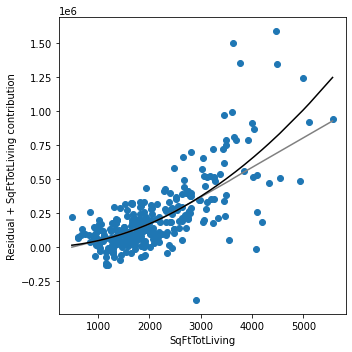

0.03879128168231147


In [ ]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105Donc possible que je serai transféré vers amsd
, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])